In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import time    

In [2]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3, shuffle=False, num_workers=1)  

validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=3, shuffle=False, num_workers=1)  


trainList = list()
validList = list()
trainLabelList = list()
validLabelList = list()

for i, data in enumerate(trainloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data


    # if you don't change the image size, it will be [batch_size, 1, 100, 100]

    batch_size = inputs.shape[0]



    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # change inputs to matrix 10000*batch_size
    for bat_idx in range(batch_size):

        targMat = inputs[bat_idx][0]

        colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')

        if(bat_idx == 0):
            batMat = colVec
        else:
            batMat = np.concatenate((batMat, colVec), axis = 1)         

    # Add ones because of the value b in coefficient
    ones = np.ones((1, batch_size), dtype = int)
    batMat = np.concatenate((batMat, ones))
    trainList.append(batMat)
    trainLabelList.append(labels)






# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data

    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
     # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]

    batch_size = inputs.shape[0]


    # Change Inputs to matrix 10000*batch_size

    for bat_idx in range(batch_size):
        targMat = inputs[bat_idx][0]
        colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')

        if(bat_idx == 0):
            batMat = colVec
        else:
            batMat = np.concatenate((batMat,colVec), axis = 1)
            



    # Add ones because of the value b in coefficient
    ones = np.ones((1, batch_size), dtype = int)
    batMat = np.concatenate((batMat, ones))
    validList.append(batMat)
    validLabelList.append(labels)




In [3]:

#Initialize Coef to Zeros
coef = np.zeros((1,10001), dtype = float)

#Set Learning Rate
lrnRate = 0.002

# Set Loss Lists
lrnLoss = list()
valLoss = list()

# Set Accurate Lists
lrnAcc = list()
valAcc = list()

# set Elapsed time Lists
elapTime = list()


epoch = -1
lrnAccRate = 0
while(lrnAccRate < 0.85):
    epoch += 1
    # load training images of the batch size for every iteration
    
    #Set Sum of Derivatives to 0
    sumDCoef = np.zeros((10001,1), dtype = float)
    
    #Set Sum of Loss to 0
    sumL = 0
    
    #Set Sum of Cor to 0
    cor = 0
    
    start_time = time.time()
    for i, batMat in enumerate(trainList):
        
        batch_size = batMat.shape[1]


        # Start Regression Calculation
        z = np.dot(coef, batMat)                                           #coef.shape = (1,10001), batMat.shape = (10001, batch_size), z.shape = (1, batch_size)
        a = 1/(1 + np.exp(-z))                                                 #a.shape = (1, batch_size)
        dz = np.subtract(a, trainLabelList[i])                                        #dz.shape = (1, batch_size)
        batMat = torch.from_numpy(batMat)                       #change ndarray to tensor
        dCoef = dz * batMat                                                 #dCoef.shape = (10001, batch_size)
        sumHelper = np.ones((batch_size,1), dtype = int)    #sumHelper.shape = (batch_size,1)
        sumDCoef += np.dot(dCoef, sumHelper)                 #sumDCoef.shape = (10001, 1)
        
        
        # Calculate Total Loss
        a = torch.from_numpy(a)                       #change ndarray to tensor
        dLabels = trainLabelList[i].double()                      #change tensor type to double
        L = -(dLabels) * np.log(a) - (1-dLabels) * np.log(1-a)      #labels.shape = (1, batch_size), L.shape = (1,batch_size)
        sumL += L.sum()
        
        
        
        # Calculate Accuracy
        

        for batIdx in range(batch_size):

            if(a[0][batIdx] <= 0.5 and trainLabelList[i][batIdx] == 0):
                cor += 1

            if(a[0][batIdx] > 0.5 and trainLabelList[i][batIdx] == 1):
                cor += 1
            
        
    
    totalDataNum = len(trainloader.dataset)
        
    # Calculate dLossdCoef

    sumDCoef /= totalDataNum

    # Update coefs using derivatives
    coef = coef.T
    coef -= lrnRate * sumDCoef
    coef = coef.T
    
    elapsed_time = time.time() - start_time
    elapTime.append(elapsed_time)


    # Calculate TotalLoss
    sumL /= totalDataNum

    lrnLoss.append(sumL)
    
    
    # Calculate Accuracy
    
    lrnAccRate = cor/totalDataNum
    lrnAcc.append(lrnAccRate)
    
                


    # Set Sum Of Valid Loss to 0
    sumVL = 0
    # Set Sum of Valid Cor to 0
    vCor = 0
    
    # load validation images of the batch size for every iteration
    for i, batMat in enumerate(validList):
        
        
        batch_size = batMat.shape[1]
        
        # Start Calculate Loss 
        z = np.dot(coef, batMat)
        a = 1/(1+np.exp(-z))
        a = torch.from_numpy(a)
        dLabels = validLabelList[i].double()
        L = -(dLabels) * np.log(a) - (1-dLabels) * np.log(1-a)
        sumVL += L.sum()

        
        # Calculate Accuracy
        
        for batIdx in range(batch_size):
            if(a[0][batIdx] <= 0.5 and validLabelList[i][batIdx] == 0):
                vCor += 1
                
            if(a[0][batIdx] > 0.5 and validLabelList[i][batIdx] == 1):
                vCor += 1
    
    totalValDataNum = len(valloader.dataset)
    
    # CalCulate Total Loss
    sumVL /= totalValDataNum
    valLoss.append(sumVL)
    
    
    # Calculate Accuracy
    vAcc = vCor/totalValDataNum
    valAcc.append(vAcc)
    
    
    print("epoch : ",epoch,',', "lrnCor : ", cor, "valCor : ", vCor, "elapsed time : ", elapsed_time)
    
    

epoch :  0 , lrnCor :  500 valCor :  128 elapsed time :  0.35717129707336426
epoch :  1 , lrnCor :  527 valCor :  128 elapsed time :  0.3743762969970703
epoch :  2 , lrnCor :  529 valCor :  128 elapsed time :  0.3772141933441162
epoch :  3 , lrnCor :  529 valCor :  128 elapsed time :  0.3679769039154053
epoch :  4 , lrnCor :  555 valCor :  129 elapsed time :  0.3654351234436035
epoch :  5 , lrnCor :  562 valCor :  135 elapsed time :  0.36958789825439453
epoch :  6 , lrnCor :  569 valCor :  140 elapsed time :  0.36948513984680176
epoch :  7 , lrnCor :  577 valCor :  149 elapsed time :  0.36916184425354004
epoch :  8 , lrnCor :  577 valCor :  160 elapsed time :  0.41475605964660645
epoch :  9 , lrnCor :  584 valCor :  176 elapsed time :  0.41450977325439453
epoch :  10 , lrnCor :  602 valCor :  183 elapsed time :  0.4842796325683594
epoch :  11 , lrnCor :  626 valCor :  189 elapsed time :  0.5107169151306152
epoch :  12 , lrnCor :  638 valCor :  199 elapsed time :  0.5565619468688965
epo

epoch :  106 , lrnCor :  786 valCor :  224 elapsed time :  0.3703773021697998
epoch :  107 , lrnCor :  787 valCor :  224 elapsed time :  0.3635139465332031
epoch :  108 , lrnCor :  788 valCor :  224 elapsed time :  0.3636598587036133
epoch :  109 , lrnCor :  788 valCor :  224 elapsed time :  0.356032133102417
epoch :  110 , lrnCor :  788 valCor :  224 elapsed time :  0.3577086925506592
epoch :  111 , lrnCor :  789 valCor :  224 elapsed time :  0.3592996597290039
epoch :  112 , lrnCor :  789 valCor :  224 elapsed time :  0.3539581298828125
epoch :  113 , lrnCor :  789 valCor :  224 elapsed time :  0.3725709915161133
epoch :  114 , lrnCor :  789 valCor :  224 elapsed time :  0.3638613224029541
epoch :  115 , lrnCor :  789 valCor :  223 elapsed time :  0.3621668815612793
epoch :  116 , lrnCor :  790 valCor :  223 elapsed time :  0.36931300163269043
epoch :  117 , lrnCor :  790 valCor :  223 elapsed time :  0.36614513397216797
epoch :  118 , lrnCor :  790 valCor :  223 elapsed time :  0.37

epoch :  211 , lrnCor :  823 valCor :  223 elapsed time :  0.49494409561157227
epoch :  212 , lrnCor :  823 valCor :  223 elapsed time :  0.4318959712982178
epoch :  213 , lrnCor :  822 valCor :  223 elapsed time :  0.40607523918151855
epoch :  214 , lrnCor :  822 valCor :  223 elapsed time :  0.5659358501434326
epoch :  215 , lrnCor :  822 valCor :  223 elapsed time :  0.4045379161834717
epoch :  216 , lrnCor :  822 valCor :  223 elapsed time :  0.4613502025604248
epoch :  217 , lrnCor :  823 valCor :  223 elapsed time :  0.39592766761779785
epoch :  218 , lrnCor :  823 valCor :  223 elapsed time :  0.40319108963012695
epoch :  219 , lrnCor :  823 valCor :  223 elapsed time :  0.3912692070007324
epoch :  220 , lrnCor :  823 valCor :  223 elapsed time :  0.37357592582702637
epoch :  221 , lrnCor :  824 valCor :  223 elapsed time :  0.3631610870361328
epoch :  222 , lrnCor :  824 valCor :  223 elapsed time :  0.3668041229248047
epoch :  223 , lrnCor :  824 valCor :  223 elapsed time :  

epoch :  316 , lrnCor :  839 valCor :  223 elapsed time :  0.3709282875061035
epoch :  317 , lrnCor :  839 valCor :  223 elapsed time :  0.36982202529907227
epoch :  318 , lrnCor :  840 valCor :  223 elapsed time :  0.5654361248016357
epoch :  319 , lrnCor :  840 valCor :  223 elapsed time :  0.5771589279174805
epoch :  320 , lrnCor :  840 valCor :  223 elapsed time :  0.5305631160736084
epoch :  321 , lrnCor :  840 valCor :  223 elapsed time :  0.5069568157196045
epoch :  322 , lrnCor :  841 valCor :  223 elapsed time :  0.7410509586334229
epoch :  323 , lrnCor :  841 valCor :  223 elapsed time :  0.8486320972442627
epoch :  324 , lrnCor :  841 valCor :  223 elapsed time :  0.5887110233306885
epoch :  325 , lrnCor :  841 valCor :  223 elapsed time :  0.789743185043335
epoch :  326 , lrnCor :  842 valCor :  223 elapsed time :  0.61844801902771
epoch :  327 , lrnCor :  841 valCor :  223 elapsed time :  0.6869511604309082
epoch :  328 , lrnCor :  841 valCor :  223 elapsed time :  0.39523

epoch :  421 , lrnCor :  856 valCor :  223 elapsed time :  0.3773989677429199
epoch :  422 , lrnCor :  856 valCor :  223 elapsed time :  0.3664240837097168
epoch :  423 , lrnCor :  856 valCor :  223 elapsed time :  0.3773331642150879
epoch :  424 , lrnCor :  856 valCor :  223 elapsed time :  0.3672950267791748
epoch :  425 , lrnCor :  857 valCor :  223 elapsed time :  0.3672018051147461
epoch :  426 , lrnCor :  857 valCor :  223 elapsed time :  0.5978350639343262
epoch :  427 , lrnCor :  857 valCor :  223 elapsed time :  0.3945028781890869
epoch :  428 , lrnCor :  857 valCor :  223 elapsed time :  0.6398851871490479
epoch :  429 , lrnCor :  858 valCor :  223 elapsed time :  0.36815404891967773
epoch :  430 , lrnCor :  859 valCor :  223 elapsed time :  0.40974998474121094
epoch :  431 , lrnCor :  860 valCor :  223 elapsed time :  0.664715051651001
epoch :  432 , lrnCor :  860 valCor :  223 elapsed time :  0.37564802169799805
epoch :  433 , lrnCor :  860 valCor :  223 elapsed time :  0.4

epoch :  526 , lrnCor :  870 valCor :  223 elapsed time :  0.3747549057006836
epoch :  527 , lrnCor :  870 valCor :  223 elapsed time :  0.3707571029663086
epoch :  528 , lrnCor :  870 valCor :  224 elapsed time :  0.3739778995513916
epoch :  529 , lrnCor :  870 valCor :  224 elapsed time :  0.36719417572021484
epoch :  530 , lrnCor :  871 valCor :  224 elapsed time :  0.3641068935394287
epoch :  531 , lrnCor :  872 valCor :  224 elapsed time :  0.36714720726013184
epoch :  532 , lrnCor :  872 valCor :  224 elapsed time :  0.3756577968597412
epoch :  533 , lrnCor :  872 valCor :  224 elapsed time :  0.36945223808288574
epoch :  534 , lrnCor :  872 valCor :  224 elapsed time :  0.3679230213165283
epoch :  535 , lrnCor :  872 valCor :  224 elapsed time :  0.36775803565979004
epoch :  536 , lrnCor :  872 valCor :  224 elapsed time :  0.36218690872192383
epoch :  537 , lrnCor :  872 valCor :  224 elapsed time :  0.3763701915740967
epoch :  538 , lrnCor :  873 valCor :  224 elapsed time :  

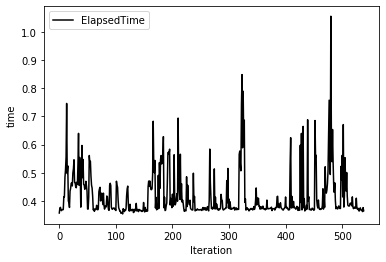

In [4]:
plt.plot(elapTime, color = 'black', label = "ElapsedTime")
plt.xlabel("Iteration")
plt.ylabel("time")
plt.legend()


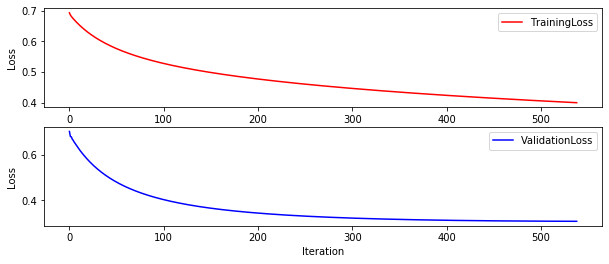

In [5]:
#Plotting Loss

fig, axs = plt.subplots(2,1, figsize = (10,4))


axs[0].plot(lrnLoss, color = 'red', label = "TrainingLoss")


axs[1].plot(valLoss, color = 'blue', label = "ValidationLoss")

axs[0].set(ylabel = 'Loss')
axs[1].set(xlabel = 'Iteration', ylabel = 'Loss')

axs[0].legend()
axs[1].legend()

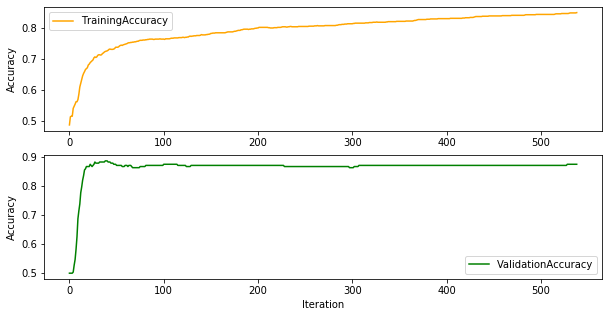

In [6]:
#Plotting Accuracy
fig, axs = plt.subplots(2,1, figsize = (10,5))


axs[0].plot(lrnAcc, color = 'orange', label = "TrainingAccuracy")


axs[1].plot(valAcc, color = 'green', label = "ValidationAccuracy")

axs[0].set(ylabel = 'Accuracy')
axs[1].set(xlabel = 'Iteration', ylabel = 'Accuracy')

axs[0].legend()
axs[1].legend()

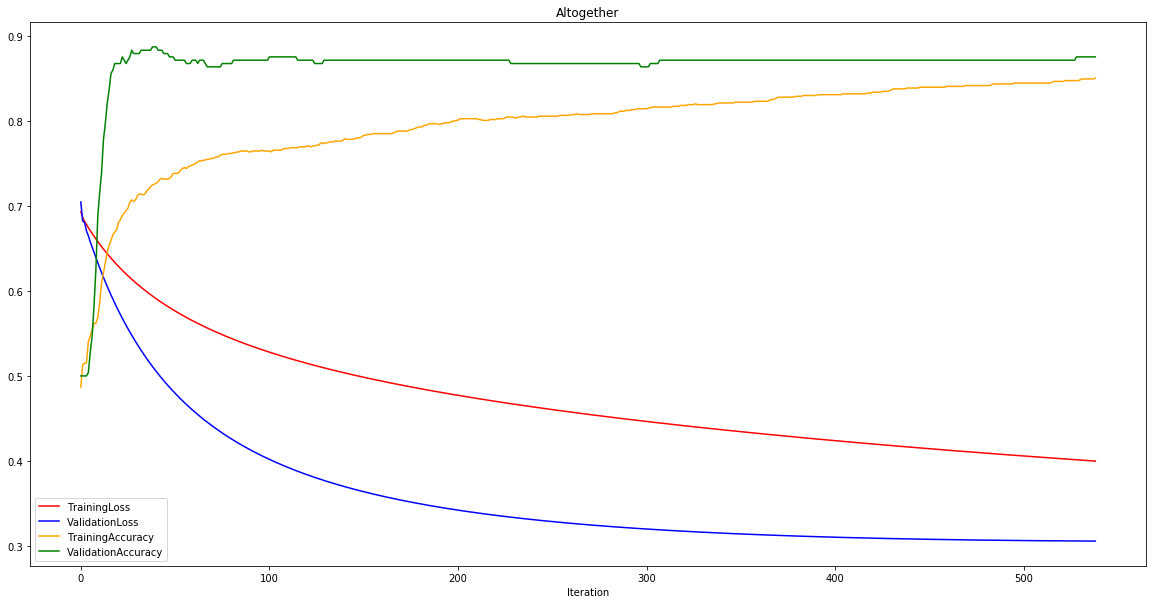

In [7]:
#Plotting Altogether

plt.figure(figsize = (20,10))
plt.title('Altogether')
plt.xlabel('Iteration')

plt.plot(lrnLoss, color = 'red', label = 'TrainingLoss')
plt.plot(valLoss, color = 'blue', label = "ValidationLoss")
plt.plot(lrnAcc, color = 'orange', label = "TrainingAccuracy")
plt.plot(valAcc, color = 'green', label = "ValidationAccuracy")

plt.legend()





In [8]:
print("  Dataset   |   Loss   | Accuracy")

print("  Training  | %.4f | %.4f" % (lrnLoss[-1], lrnAcc[-1]))
print(" Validation| %.4f | %.4f" % (valLoss[-1], valAcc[-1]))

  Dataset   |   Loss   | Accuracy
  Training  | 0.3999 | 0.8500
 Validation| 0.3059 | 0.8750
